In [1]:
# SETUP

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import xarray as xr
from sklearn.model_selection import StratifiedShuffleSplit

import shap
import re

sns.set('paper', style='whitegrid')

In [2]:
INPUT_NAME = 'connectivities_classifier-SVML1_measure-accuracy_top-10_cv-100x4fold'

RESULTS = xr.open_dataset(f'models/{INPUT_NAME}.nc').load()

RESULTS

<xarray.Dataset>
Dimensions:                                         (shap_dim: 800,
                                                     difumo_64_2mm_feature: 136,
                                                     gordon2014_2mm_feature: 91,
                                                     dosenbach2010_feature: 21,
                                                     permutation_importance_num: 500,
                                                     subject: 32,
                                                     grid_model_name: 15,
                                                     model_name: 10,
                                                     cv_dim: 100,
                                                     permutation_dim: 10,
                                                     learning_curve_num: 5,
                                                     y_classes: 2)
Coordinates:
  * difumo_64_2mm_feature                           (difumo_64_2mm_feature) object ...
  * gordon2014_2mm_feature                          (gordon2014_2mm_feature) object ...
  * dosenbach2010_feature                           (dosenbach2010_feature) object ...
  * grid_model_name                                 (grid_model_name) object ...
  * model_name                                      (model_name) object 'dose...
  * learning_curve_num                              (learning_curve_num) int32 ...
  * y_classes                                       (y_classes) object 'AVGP'...
Dimensions without coordinates: shap_dim, permutation_importance_num, subject,
                                cv_dim, permutation_dim
Data variables: (12/171)
    difumo_64_2mm precision shap                    (shap_dim, difumo_64_2mm_feature) float64 ...
    difumo_64_2mm precision shap data               (shap_dim, difumo_64_2mm_feature) float64 ...
    gordon2014_2mm tangent shap                     (shap_dim, gordon2014_2mm_feature) float64 ...
    gordon2014_2mm tangent shap data                (shap_dim, gordon2014_2mm_feature) float64 ...
    gordon2014_2mm partial correlation shap         (shap_dim, gordon2014_2mm_feature) float64 ...
    gordon2014_2mm partial correlation shap data    (shap_dim, gordon2014_2mm_feature) float64 ...
    ...                                              ...
    learning_curve_train_size                       (learning_curve_num) int32 ...
    learning_curve_mean_train_score                 (learning_curve_num) float64 ...
    learning_curve_mean_test_score                  (learning_curve_num) float64 ...
    cv_test_size                                    int32 8
    cv_n_splits                                     int32 100
    n_subjects                                      int32 32

In [3]:
# prep grid data

n_subjects = RESULTS['n_subjects'].item()
X = RESULTS['X'].values
y = RESULTS['y'].values
cv_n_splits = RESULTS['cv_n_splits'].item()
cv_test_size = RESULTS['cv_test_size'].item()
scoring = RESULTS['scoring'].item()


split_score_cols = [c for c in list(RESULTS.keys()) if re.match(r'split\d+_test_score', c)]
grid_cv_results = RESULTS[split_score_cols + ['rank_test_score', 'mean_test_score']].to_pandas()
grid_cv_results.index.name = 'label'
grid_cv_results = grid_cv_results.reset_index()

scores = grid_cv_results
# scores['label'] = scores['params'].apply(lambda p: ' '.join(p.values()))
split_score_cols = [c for c in scores.columns if 'split' in c]
scores['test_score'] = scores[split_score_cols].apply(lambda x: list(x), axis=1)
scores = scores.explode('test_score').reset_index(drop=True)
scores = scores.sort_values('rank_test_score', ascending=False)

scores[['atlas','kind']] = scores['label'].apply(
    lambda x: x.replace('partial correlation', 'partial_correlation').split(' ')).apply(pd.Series)

scores = scores[['label', 'atlas', 'kind', 'test_score', 'mean_test_score']]

# simulate chance
chance_scores = {}
for model_name in scores['label'].unique():
    chance_model = DummyClassifier(strategy='stratified').fit(X, y)
    _chance_scores = cross_val_score(chance_model, X, y,
                                     cv=StratifiedShuffleSplit(n_splits=cv_n_splits, test_size=cv_test_size), scoring=scoring)
    chance_scores[model_name] = _chance_scores

chance_scores = pd.DataFrame(chance_scores)
chance_scores = chance_scores.melt(value_name=scoring, var_name='label')

# sort, mean score and ordering
scores = scores.sort_values('mean_test_score', ascending=True)
mean_scores = scores.groupby('label')[['test_score']].mean().reset_index()
order = scores['label'].drop_duplicates()

# percentage accuracy
scores['accuracy_pct'] = scores['test_score'] * 100.0
chance_scores['accuracy_pct'] = chance_scores['accuracy'] * 100.0
mean_scores['accuracy_pct'] = mean_scores['test_score'] * 100.0


In [12]:
# Calculate and report 95% confidence intervals

from scipy.stats import bootstrap
import numpy as np

def calculate_ci(scores):
    bootstrap_ci = bootstrap((scores.values,), np.mean, confidence_level=0.95, method='percentile')

    return bootstrap_ci.confidence_interval.low, bootstrap_ci.confidence_interval.high


scores.groupby(['atlas','kind'])['accuracy_pct'].apply(calculate_ci)

atlas           kind               
difumo_64_2mm   correlation                       (46.875, 51.875)
                covariance                           (42.0, 47.25)
                partial_correlation                (47.625, 53.75)
                precision                            (53.75, 59.5)
                tangent                            (42.25, 48.625)
dosenbach2010   correlation                         (57.625, 63.0)
                covariance                         (48.875, 55.25)
                partial_correlation               (69.875, 75.375)
                precision                         (60.875, 66.875)
                tangent                (65.86875000000003, 71.625)
gordon2014_2mm  correlation                         (45.875, 52.5)
                covariance                        (54.125, 60.125)
                partial_correlation               (57.375, 62.625)
                precision                             (55.0, 62.0)
                tangent   

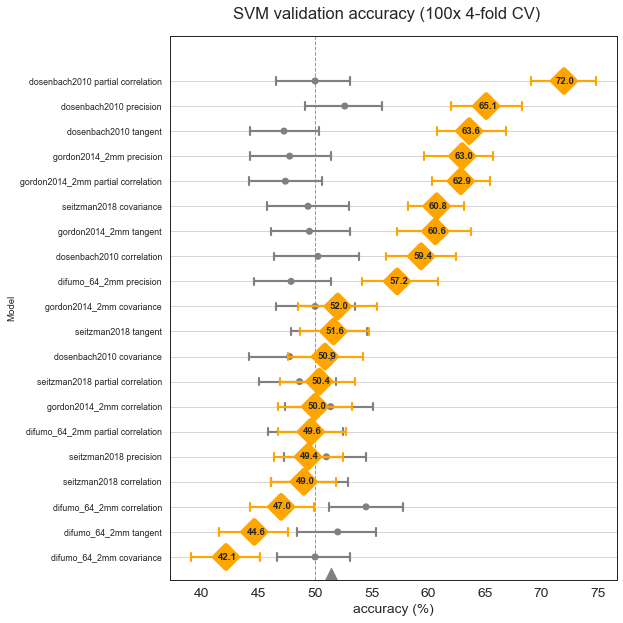

In [16]:
sns.set('paper', 'white')
_, ax = plt.subplots(figsize=(8, len(RESULTS['grid_model_name']) * .5))

def jitter(df, column='cv_test_score', jitter_size=.03):
    jittered_df = df.copy()
    jittered_df[column] = jittered_df[column] + np.random.uniform(-jitter_size, jitter_size, len(df))
    return jittered_df    

# chance
g = sns.pointplot(data=chance_scores,
              x='accuracy_pct', y='label',
              order=order,
              join=False,
            #   markers='D',
              color='gray',
              capsize=0.3,
              cmap='viridis',
              size=5, ax=ax,
              label='chance')
# plt.setp(g.collections, alpha=.3) # alpha the markers
# plt.setp(g.lines, alpha=.3) # alpha the lines

# observation
sns.pointplot(data=scores,
              x='accuracy_pct', y='label', order=order,
              join=False,
              color='orange',
              markers='D',
              capsize=0.3,
              scale=3,
              cmap='viridis',
              plot_kws=dict(zorder=1),
              ax=ax,
              label='observation')

# annotate the mean points
y_ticklabels = [t.get_text() for t in ax.get_yticklabels()]
for i, model_name, cv_test_score, accuracy_pct in mean_scores.itertuples():
    ticklabel_idx = y_ticklabels.index(model_name)
    ax.annotate(f'{accuracy_pct:.1f}', (accuracy_pct-.7, ticklabel_idx-0.1), weight='bold')

ax.grid(axis='y')

ax.axvline(x=50, linestyle='--', color='gray', linewidth=1, alpha=.8, label='theoretical chance', zorder=-1)

ax.scatter([51.4], [-.7], marker='^', s=160, color='gray')

ax.set(ylabel='Model', ylim=(-.9, len(order)+.8))
ax.set_xlabel('accuracy (%)', fontsize='x-large')

# plt.legend().set_visible(False)
# plt.legend()

plt.xticks(fontsize='x-large')

plt.suptitle(f'SVM validation accuracy ({cv_n_splits}x 4-fold CV)', fontsize='xx-large', y=.92)
plt.savefig(f'outputs/connectivities/{INPUT_NAME}.svg')